In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import libraries for clustering
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from geopy.distance import great_circle

In [3]:
# import libraries for spi calculation
import xarray as xr
from scipy import stats as st
from shapely.geometry import mapping
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from geopy.distance import great_circle

In [4]:
# load open building data
buildings_central = pd.read_csv('./data/buildings_central.csv')

In [5]:
# load chirps precipitation data
pr_ghana = xr.open_dataset('./data/chirps-v2.0.monthly_ghana.nc')

In [6]:
# load region boundaries of Ghana
ghana_admin = gpd.read_file('./data/GHA_adm1.shp')

In [7]:
# select Ghana's central region
central_gha = ghana_admin[ghana_admin['NAME_1'] == 'Central']

In [8]:
# reduce number of buildings
sample_size = 200000
buildings_sample = (buildings_central.sample(sample_size)
                    if len(buildings_central) > sample_size else buildings_central)

# Cluster buildings

In [9]:
# get coordinates
coords = buildings_sample[['latitude','longitude']].values

In [10]:
# set max distance to 1.5 km from each other
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
# compute dbscan
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
# get number of clusters
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 75


In [11]:
# finding each cluter's center-most point
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [12]:
centermost_points = clusters.map(get_centermost_point)

In [13]:
# convert cluster center to dataframe
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'longitude':lons, 'latitude':lats})

In [14]:
# link cluster to clipped dataframe
rs = rep_points.apply(lambda row: buildings_sample[(buildings_sample['latitude']==row['latitude']) | (buildings_sample['longitude']==row['longitude'])].iloc[0], axis=1)

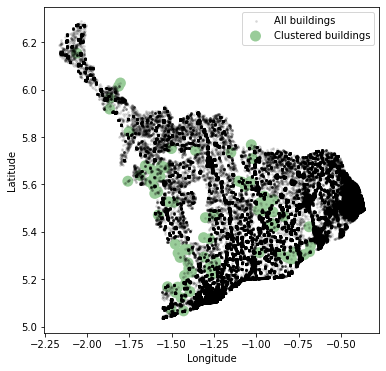

In [15]:
# plot all stations vs clustered stations
fig, ax = plt.subplots(figsize=[6, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=1, s=120)
df_scatter = ax.scatter(buildings_sample['longitude'], buildings_sample['latitude'], c='k', alpha=0.1, s=3)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['All buildings', 'Clustered buildings'], loc='upper right')
plt.show()

In [16]:
# convert dataframe to geodataframe
geometry = [Point(xy) for xy in zip(rs['longitude'], rs['latitude'])]
crs = 'EPSG:4326'
buildings_cluster = gpd.GeoDataFrame(rs, crs=crs, geometry=geometry)

# Calculate SPI

In [17]:
# load chirps precipitation data
pr_ghana = xr.open_dataset('./data/chirps-v2.0.monthly_ghana.nc')

In [18]:
# select precipitaion variable
pr_ghana = pr_ghana['precip']

In [19]:
# Standardized Precipitation Index Function
def spi(ds, thresh, dimension):
    #ds - data ; thresh - time interval / scale; dimension - dimension as a string
    
    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(time = thresh, center=False).mean(dim=dimension)
    
    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In = ds_In.where(np.isinf(ds_In) == False) #= np.nan  #Change infinity to NaN
    
    ds_mu = ds_ma.mean(dimension)
    
    #Overall Mean of Moving Averages
    ds_mu = ds_ma.mean(dimension)
    
    #Summation of Natural log of moving averages
    ds_sum = ds_In.sum(dimension)
    
    #Computing essentials for gamma distribution
    n = ds_In[thresh-1:, :, :].count(dimension)                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)
    
    #Gamma Distribution (CDF) 
    gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)
    gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)
    
    #Standardized Precipitation Index   (Inverse of CDF)
    norminv = lambda data: st.norm.ppf(data, loc=0, scale=1)
    norm_spi = xr.apply_ufunc(norminv, gamma)  #loc is mean and scale is standard dev.
    
    return ds_ma, ds_In , ds_mu, ds_sum,n, A, alpha, beta, gamma, norm_spi

In [20]:
# perform spi computation
months = [1]
for i in months:
    x = spi(pr_ghana, i, 'time')
    pr_ghana['spi_'+str(i)] = x[9]

<ipython-input-19-754f49fe5ded>:6: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  ds_ma = ds.rolling(time = thresh, center=False).mean(dim=dimension)


In [21]:
pr_ghana

<xarray.DataArray 'precip' (time: 494, latitude: 130, longitude: 90)>
array([[[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.81878 , 0.50085 , ..., 0.314514, 0.044294],
        [0.759628, 0.553108, ..., 0.105816, 0.061246]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [1.285886, 0.945782, ..., 1.578728, 0.614722],
        [1.235717, 0.954193, ..., 1.391041, 0.957207]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.88516 , 0.541574, ..., 0.254303, 0.037134],
        [0.820905, 0.597333, ..., 0.085393, 0.049747]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [1.306671, 0.994796, ..., 1.271593, 0.47385 ],
        [1.231126, 1.013104, ..., 1.140564, 0.736987]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 4.725 4.775 4.825 4.875 ... 11.07 11.12 11.17
  * longitude  (longitude) float32 -3.275 -3.225 -3.175 ... 1.075 1.125 1.175
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2022-02-01
    spi_1      (time, latitude, longitude) float64 nan nan nan ... -1.12 -1.168
Attributes:
    units:               mm/month
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           month
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

# Latest Drought Exposure Location

In [22]:
# select latest month spi
pr_ghana = pr_ghana['spi_1'].sel(time='2022-02-01')

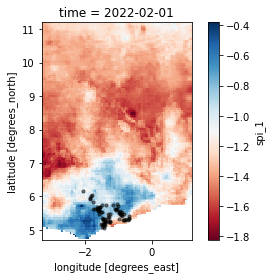

In [23]:
# plot latest spi with clustered buildings
base = buildings_cluster.plot(zorder=2, markersize=10, color='black', alpha=0.5)
pr_ghana.plot(cmap='RdBu', ax=base)

In [24]:
# add projection system to nc
pr_ghana = pr_ghana.rio.write_crs('EPSG:4326', inplace=True)

In [25]:
# create new xarray containing spi_1 values only for selected by building coordinates
buildings_spi = pr_ghana.rio.clip(buildings_cluster.geometry.apply(mapping), buildings_cluster.crs, drop=False)
# convert xarray to dataframe and drop missing values 
buildings_spi = buildings_spi.to_dataframe().dropna().reset_index()
# drop duplicated spi_1 columns, time and spatial_ref column
buildings_spi = buildings_spi.T.drop_duplicates().T.drop(columns=['time','spatial_ref'])

In [26]:
# convert dataframe to geodataframe
geometry = [Point(xy) for xy in zip(buildings_spi['longitude'], buildings_spi['latitude'])]
crs = 'EPSG:4326'
buildings_spi = gpd.GeoDataFrame(buildings_spi, crs=crs, geometry=geometry)

In [27]:
buildings_spi.head(2)

,latitude,longitude,spi_1,geometry
0,5.074997,-1.525009,-0.845617,POINT (-1.52501 5.07500)
1,5.074997,-1.425003,-1.02532,POINT (-1.42500 5.07500)


In [28]:
# set dtype of spi to float
buildings_spi['spi_1'] = buildings_spi['spi_1'].astype('float32')

Text(0.5, 1.0, 'Drought Exposure of February 2022')

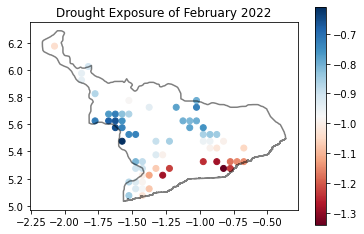

In [29]:
base = central_gha.boundary.plot(zorder=2, color='black', alpha=0.5)
buildings_spi.plot(column='spi_1', cmap='RdBu', legend='True', ax=base)
base.set_title("Drought Exposure of February 2022")

In [30]:
buildings_spi

,latitude,longitude,spi_1,geometry
0,5.074997,-1.525009,-0.845617,POINT (-1.52501 5.07500)
1,5.074997,-1.425003,-1.025320,POINT (-1.42500 5.07500)
2,5.125,-1.475006,-0.921850,POINT (-1.47501 5.12500)
3,5.125,-1.425003,-0.971811,POINT (-1.42500 5.12500)
4,5.125,-1.375,-1.075679,POINT (-1.37500 5.12500)
...,...,...,...,...
60,5.824997,-1.775009,-0.870189,POINT (-1.77501 5.82500)
61,5.924999,-1.875,-0.944120,POINT (-1.87500 5.92500)
62,5.974998,-1.875,-0.944223,POINT (-1.87500 5.97500)
63,6.024998,-1.824997,-0.908095,POINT (-1.82500 6.02500)


In [31]:
# save latest drought exposure location
#buildings_spi.to_file('./data/buildings_spi.shp')